In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [19]:
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

torch.manual_seed(42)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Total graphs: {len(dataset)}")
print(f"Train graphs: {len(train_dataset)}")
print(f"Test graphs: {len(test_dataset)}")
print(f"Node features: {dataset.num_node_features}")
print(f"Classes: {dataset.num_classes}")

Total graphs: 188
Train graphs: 150
Test graphs: 38
Node features: 7
Classes: 2


In [20]:
class GraphSAGEClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

In [22]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x.float(), data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.num_graphs
    return correct / total

In [23]:
epochs = 50
train_losses = []
train_accs = []
test_accs = []

for epoch in range(epochs):
    loss = train()
    train_acc = evaluate(train_loader)
    test_acc = evaluate(test_loader)

    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1:02d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 01 | Loss: 0.6486 | Train Acc: 0.6933 | Test Acc: 0.5526
Epoch 02 | Loss: 0.6111 | Train Acc: 0.6933 | Test Acc: 0.5526
Epoch 03 | Loss: 0.5975 | Train Acc: 0.6933 | Test Acc: 0.5526
Epoch 04 | Loss: 0.5911 | Train Acc: 0.6933 | Test Acc: 0.5526
Epoch 05 | Loss: 0.5723 | Train Acc: 0.6933 | Test Acc: 0.5789
Epoch 06 | Loss: 0.5578 | Train Acc: 0.7133 | Test Acc: 0.5789
Epoch 07 | Loss: 0.5646 | Train Acc: 0.7067 | Test Acc: 0.5789
Epoch 08 | Loss: 0.5595 | Train Acc: 0.7200 | Test Acc: 0.6053
Epoch 09 | Loss: 0.5417 | Train Acc: 0.7533 | Test Acc: 0.6579
Epoch 10 | Loss: 0.5004 | Train Acc: 0.7467 | Test Acc: 0.6053
Epoch 11 | Loss: 0.5147 | Train Acc: 0.7667 | Test Acc: 0.6842
Epoch 12 | Loss: 0.4997 | Train Acc: 0.7667 | Test Acc: 0.6842
Epoch 13 | Loss: 0.4876 | Train Acc: 0.7800 | Test Acc: 0.6579
Epoch 14 | Loss: 0.4843 | Train Acc: 0.7800 | Test Acc: 0.6842
Epoch 15 | Loss: 0.4800 | Train Acc: 0.7800 | Test Acc: 0.6842
Epoch 16 | Loss: 0.4739 | Train Acc: 0.7733 | Test Acc:

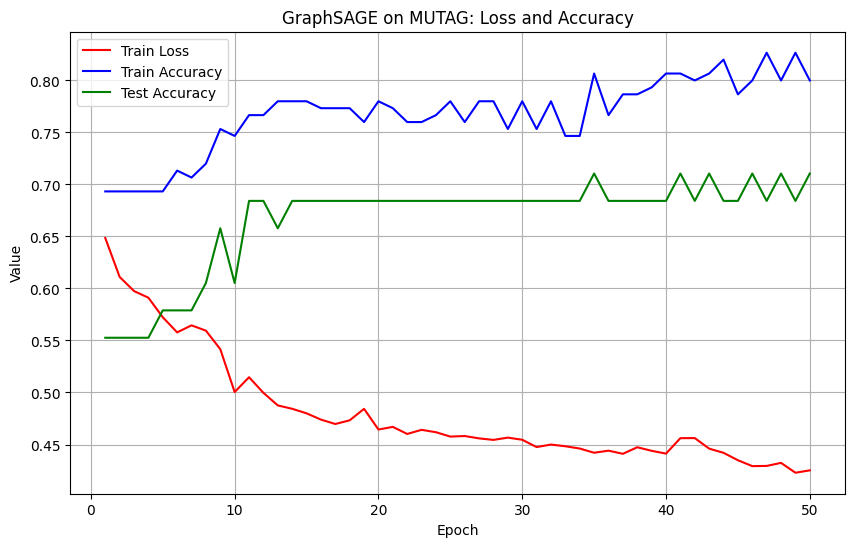

In [24]:
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='red')
plt.plot(range(1, epochs+1), train_accs, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), test_accs, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('GraphSAGE on MUTAG: Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()

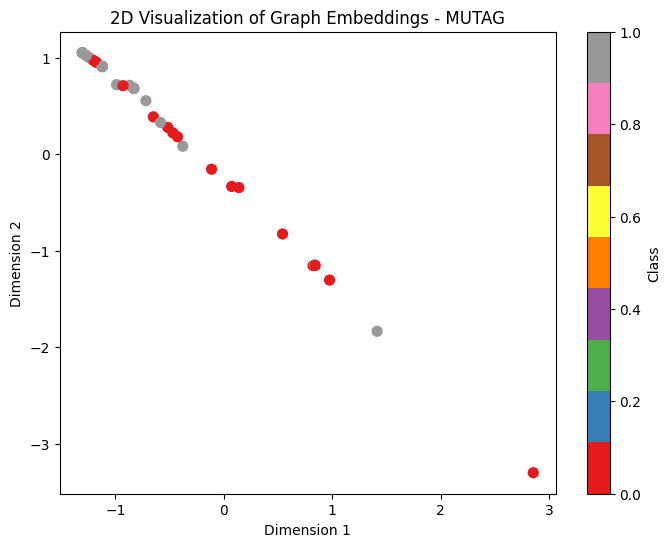

In [28]:
@torch.no_grad()
def get_embeddings(loader):
    model.eval()
    embeddings = []
    labels = []
    for data in loader:
        data = data.to(device)
        out = model(data.x.float(), data.edge_index, data.batch)
        embeddings.append(out.cpu())
        labels.append(data.y.cpu())
    return torch.cat(embeddings, dim=0), torch.cat(labels, dim=0)

embeddings, labels = get_embeddings(test_loader)


plt.figure(figsize=(8,6))
plt.scatter(embeddings[:,0], embeddings[:,1], c=labels, cmap='Set1', s=50)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Graph Embeddings - MUTAG')
plt.colorbar(label='Class')
plt.show()
